## configs

In [4]:
cleansed = '/Users/beantown/PycharmProjects/master-thesis/data/processed/03_post_cleansing'
path = '/Users/beantown/PycharmProjects/master-thesis/data/processed/'
# n = number of patches retrived from one papyry 
n = 10
# metric used to selecet patches
metric = 'preferText'
# size of the patch should be nxn and not nxm!
patch_size_width = 64
patch_size_height = 64

## Import dependencies 

In [5]:
import pandas as pd
from os.path import join, isfile
from skimage import io
from sklearn.feature_extraction.image import extract_patches_2d
import matplotlib.pyplot as plt
import torch
import torchvision.transforms
import torch.nn.functional as F
import numpy as np
from skimage.metrics import structural_similarity
import numpy as np
import skimage
from skimage import measure
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import itertools
import plotly.express as px

In [6]:
def create_processed_info(path, debug=False):
    if debug:
        info_path = join(path, 'debug_processed_info.csv')
    else:
        info_path = join(path, 'processed_info.csv')
    if isfile(info_path):
        processed_frame = pd.read_csv(info_path, index_col=0,
                                      dtype={'fnames': str, 'papyID': int, 'posinfo': str, 'pixelCentimer': float},
                                      header=0)
    else:
        fnames = [f for f in listdir(path) if isfile(join(path, f))]
        fnames = [x for x in fnames if ".png" in x]
        fnames = [f.split('.', 1)[0] for f in fnames]
        fnames_frame = pd.DataFrame(fnames, columns=['fnames'])
        fragmentID = pd.DataFrame([f.split('_', 1)[0] for f in fnames], columns=['fragmentID'])
        fnames_raw = [f.split('_', 1)[1] for f in fnames]
        processed_frame = pd.DataFrame(fnames_raw, columns=['fnames_raw'])

        processed_frame = pd.concat([processed_frame, fnames_frame], axis=1)

        processed_frame = pd.concat([processed_frame, fragmentID], axis=1)
        processed_frame['papyID'] = processed_frame.fnames_raw.apply(lambda x: x.split('_', 1)[0])
        processed_frame['posinfo'] = processed_frame.fnames_raw.apply(lambda x: ''.join(filter(str.isalpha, x)))
        processed_frame['pixelCentimer'] = processed_frame.fnames_raw.progress_apply(retrive_size_by_fname)
        processed_frame.to_csv(info_path)

    return processed_frame

In [7]:
df = create_processed_info(cleansed)

In [8]:
print(f"Dataset len = {len(df)}")

Dataset len = 9970


In [9]:
print(f"Dataset len = {len(df)}")

Dataset len = 9970


## Example for one image

In [10]:
img = io.imread(cleansed + '/' + df.loc[1].fnames + '.png')

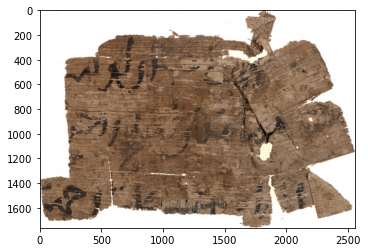

In [11]:
plt.imshow(img)
plt.show()

In [12]:
height = img.shape[0]
width = img.shape[1]
print(f"Img height = {height} and width = {width}")

Img height = 1763 and width = 2553


In [13]:
x = torch.tensor(np.array([img.T]))
x.shape
x[0][0][0]

tensor([255, 255, 255,  ..., 255, 255, 255], dtype=torch.uint8)

In [14]:
#x = torch.randn(1, 3, 220, 156)
kc, kh, kw = 3, 128, 128  # kernel size
dc, dh, dw = 3, 128, 128  # stride
# Pad to multiples of 32
x = F.pad(x, (x.size(2)%kw // 2, x.size(2)%kw // 2,
              x.size(1)%kh // 2, x.size(1)%kh // 2,
              x.size(0)%kc // 2, x.size(0)%kc // 2), mode='constant',value=255)

patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
unfold_shape = patches.size()
patches = patches.contiguous().view(-1, kc, kh, kw)
print(patches.shape)

torch.Size([266, 3, 128, 128])


In [15]:
patches_orig = patches.view(unfold_shape)
output_c = unfold_shape[1] * unfold_shape[4]
output_h = unfold_shape[2] * unfold_shape[5]
output_w = unfold_shape[3] * unfold_shape[6]
patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
patches_orig = patches_orig.view(1, output_c, output_h, output_w)

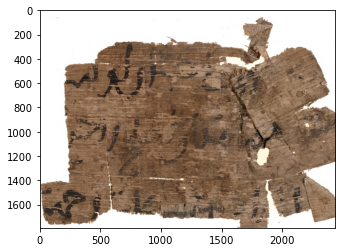

In [16]:
plt.imshow(patches_orig[0].numpy().T)
plt.show()

In [17]:
patches = patches.numpy()

In [18]:
patches.shape

(266, 3, 128, 128)

In [19]:


#image = np.arange(1, 10).reshape((3, 3))
labels = np.ones_like(img, dtype=int)

# arguments must be in the specified order, matching regionprops
def image_stdev(region, intensities):
    # note the ddof arg to get the sample var if you so desire!
    return np.std(intensities[region], ddof=1)
props = measure.regionprops(
    labels, img, extra_properties=[image_stdev]
)

org_var = props[0].image_stdev

In [20]:
similarities = []
list2 = []
for patch in patches:
    if np.mean(patch)>=np.mean(img):
        list2.append(patch)
        labels = np.ones_like(patch.T, dtype=int)
        variance = measure.regionprops(labels, patch.T, extra_properties=[image_stdev])[0].image_stdev
        similarities.append(variance)

In [21]:
list1 = np.array(similarities)
idx   = np.argsort(list1)
list1 = np.array(list1)[idx]
list2 = np.array(list2)[idx]

In [22]:
len(list1)

91

In [23]:
len(list2)

91

In [24]:
results = list2[list2.shape[0]-n:]

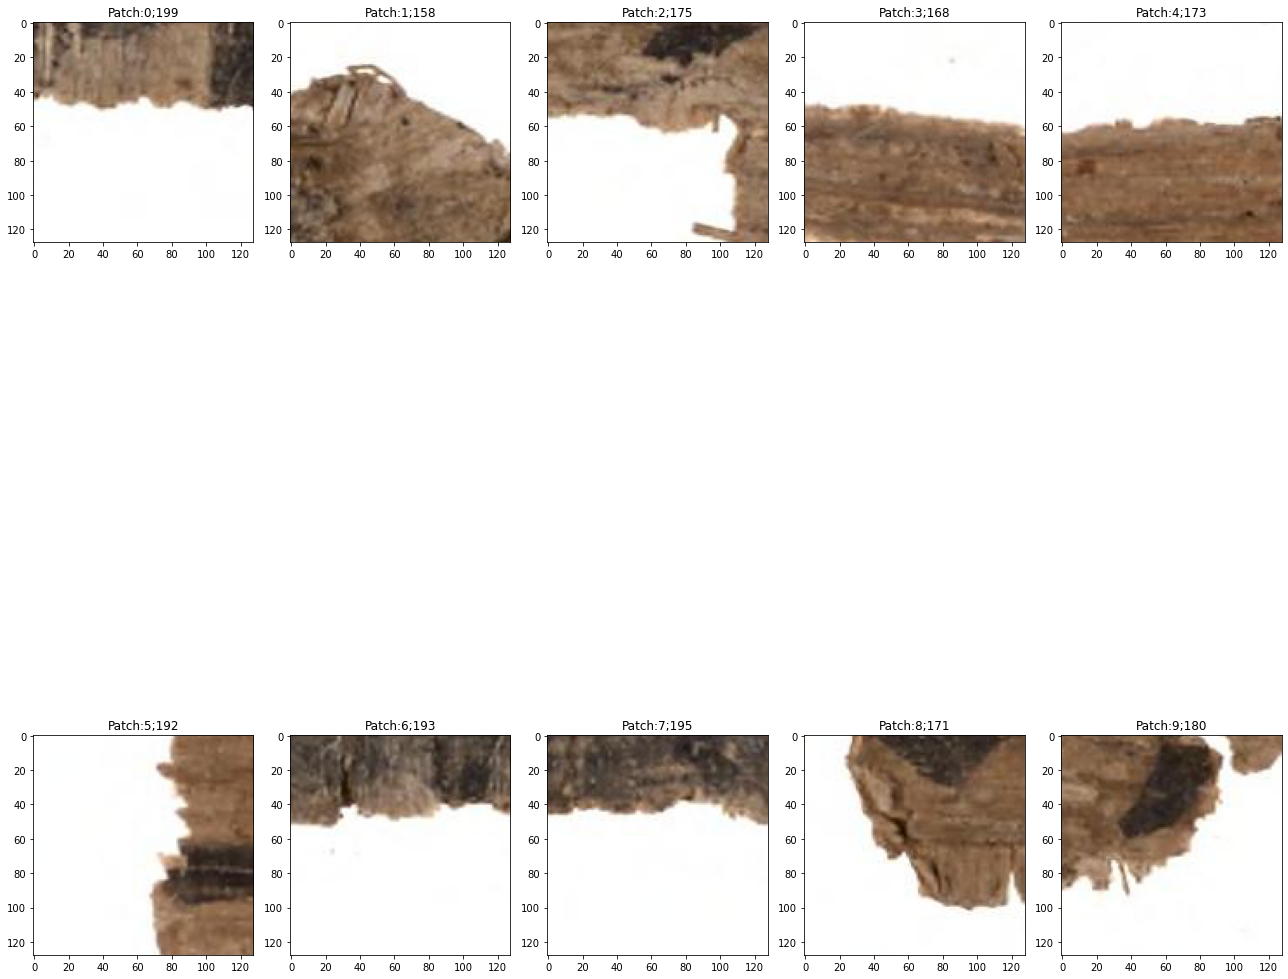

In [25]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 26))
columns = 5
rows = 2


# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("Patch:"+str(i)+  ';'+ str(round(np.mean(results[i].T))))  # set title
    plt.imshow(results[i].T)


plt.tight_layout()
plt.show()

## Execute for alles images

In [26]:
# arguments must be in the specified order, matching regionprops
def image_stdev(region, intensities):
    # note the ddof arg to get the sample var if you so desire!
    return np.std(intensities[region], ddof=1)

In [27]:
def check_patch(metric):
    """
    Wrapper function too check weather a patch fits to metric or not
    Args:
        metric:

    Returns:

    """

def create_dataset_1(df, n, m, name, path, decending):
    new_df = pd.DataFrame(columns = ['image',
                                 'label',
                                 'original_image',
                                 'train',
                                 'test',
                                 'val',
                                 'position',
                                 'fragment',
                                'patch'
                                 'pixelcm'])
    for i in tqdm(range(len(df))):
        # get img from dataset
        img = io.imread(cleansed + '/' + df.loc[i].fnames + '.png')

        # use torch -> cast2 tensor
        x = torch.tensor(np.array([img.T]))

        # define patch size properties for padding and unfolding
        kc, kh, kw = 3, m, m  # kernel size
        dc, dh, dw = 3, m, m  # stride

        # Pad to multiples of m
        x = F.pad(x, (x.size(2)%kw // 2, x.size(2)%kw // 2,
                      x.size(1)%kh // 2, x.size(1)%kh // 2,
                      x.size(0)%kc // 2, x.size(0)%kc // 2), mode='constant',value=255)

        #create_patches
        patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
        patches = patches.contiguous().view(-1, kc, kh, kw)

        # evaluate patch -> cast2 numpy
        patches = patches.numpy()
        selected_metric_values = []
        selected_patches = []
        selected_patch_ids = []

        for patch_id, patch in enumerate(patches):
            #check if patch fits to metric

            if skimage.exposure.is_low_contrast(patch, fraction_threshold=0.025, lower_percentile=1, upper_percentile=99, method='linear') == False:
                selected_patches.append(patch)
                labels = np.ones_like(patch.T, dtype=int)                
                variance = measure.regionprops(labels, patch.T, extra_properties=[image_stdev])[0].image_stdev
                selected_metric_values.append(variance)
                selected_patch_ids.append(patch_id)

        # sort
        selected_metric_values = np.array(selected_metric_values)
        idx   = np.argsort(selected_metric_values)
        selected_patches = np.array(selected_patches)[idx]
        selected_patch_ids = np.array(selected_patch_ids)[idx]

        # get the first n patches which have the HIGHEST metric (e.g. variance)
        if decending:
            results = selected_patches[selected_patches.shape[0]-n:]
        else:
            results = selected_patches[:n]


        for j, result in enumerate(results):
            # save the patch with the patch ID in front
            io.imsave(path + name + '/' + str(j) + '_'+ df.loc[i].fnames +  '.jpg', result.T)

            # append row too new dataframe with image, label, original_img
            new_df = new_df.append({'image' : str(j) + '_'+ df.loc[i].fnames +  '.jpg',
                            'label' : df.loc[i].papyID,
                            'original_image' : df.loc[i].fnames + '.png',
                            'train':True,
                            'test':False,
                            'val':False,
                            'position': df.loc[i].posinfo,
                            'fragment':df.loc[i].fragmentID,
                            'patch':j,
                            'pixelcm':df.loc[i].pixelCentimer
                            },ignore_index = True)

    new_df.to_csv(path + name + 'info.csv')

In [33]:
# uncoment when you want to recreate features for dataset 1. Make sure path is empty. 
#create_dataset_1(df=df, n=10, m=64, name='dataset_1/', path=path, decending=True)

100%|█████████████████████████████████████████████████████████████████████| 9970/9970 [2:11:58<00:00,  1.26it/s]


In [40]:
def create_train_val_test_frames(processed_frame):
    id_series = processed_frame.groupby('label')['image'].nunique().sort_values(ascending=False)
    id_frame = pd.DataFrame(id_series)
    base_line_papyris = id_frame[id_frame.image != 1].index
    df = processed_frame[processed_frame['label'].isin(base_line_papyris)]
    
    #get_cleand_papyri_hist(df, title = 'Histogram Fragments / Papyri  [removed papyris with just on fragment]', fig_name= 'HistogramFragAfter_2.pdf')
    
    id_series = df.groupby('label')['image'].nunique().sort_values(ascending=False)
    counts = np.bincount(id_series)

    def remove_empty_bins(counts):
        ticks = range(len(counts))
        new_ticks = []
        new_counts = []
        for tick, count in zip(ticks, counts):
            if count != 0:
                new_ticks.append(str(tick))
                new_counts.append(count)
        return new_ticks, new_counts

    frags_per_papyri, counts = remove_empty_bins(counts)
    
    train_ids = []
    val_ids = []
    test_ids = []

    for frag_per_papyri in frags_per_papyri:
        id_series = df.groupby('label')['image'].nunique().sort_values(ascending=False)
        ids = id_frame[id_frame.image == int(frag_per_papyri)].index
        if len(ids) <= 3:
            train_ids.append(ids[0])
        else:
            train, test = train_test_split(ids, test_size=0.1, random_state=44)
            train, val = train_test_split(train, test_size=0.11, random_state=44)
            train_ids = list(itertools.chain(train_ids, train))
            val_ids = list(itertools.chain(val_ids, val))
            test_ids = list(itertools.chain(test_ids, test))
            
    print(f'# of IDs in train = {len(train_ids)}')
    print(f'# of IDs in val = {len(val_ids)}')
    print(f'# of IDs in test = {len(test_ids)}')
    
    train_frame = df[df['label'].isin(train_ids)]
    val_frame = df[df['label'].isin(val_ids)]
    test_frame = df[df['label'].isin(test_ids)]
    
    print(f'# of IDs in train = {len(train_frame.label.unique())}')
    print(f'# of IDs in val = {len(val_frame.label.unique())}')
    print(f'# of IDs in test = {len(test_frame.label.unique())}')
    
    
    return train_frame, test_frame, val_frame

In [31]:
new_df = pd.read_csv(path + 'dataset_1/' + 'info.csv')

In [45]:
train, test, val = create_train_val_test_frames(new_df)

# of IDs in train = 4823
# of IDs in val = 603
# of IDs in test = 609
# of IDs in train = 4823
# of IDs in val = 603
# of IDs in test = 609


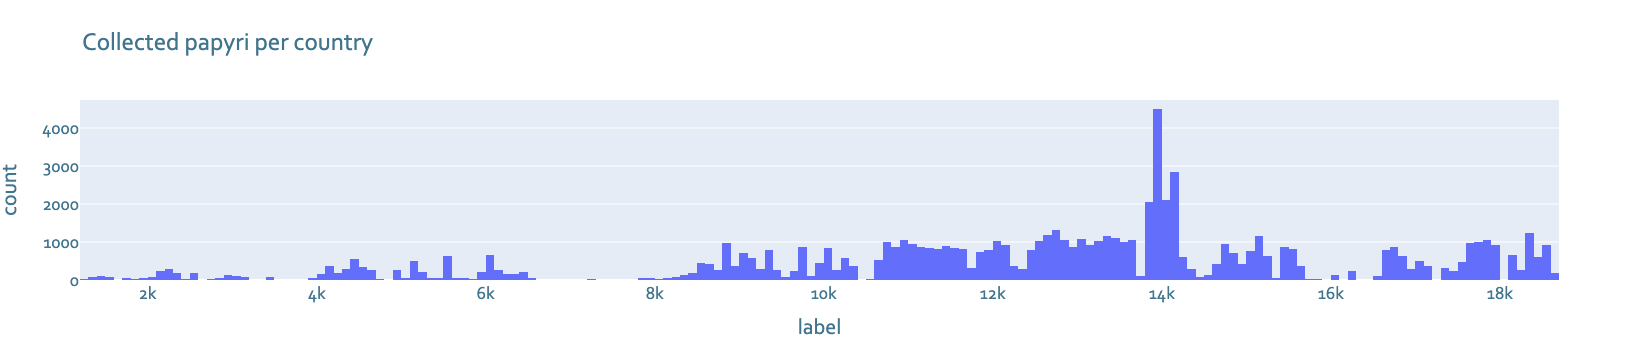

In [49]:
fig = px.histogram(train, x="label", title="Collected papyri per country")
fig.update_layout(
    autosize=True,
    font=dict(family="Corbel",size=18,color='rgb(65,116,141)'),
    #legend_title_font_color="green",
)

fig.show()

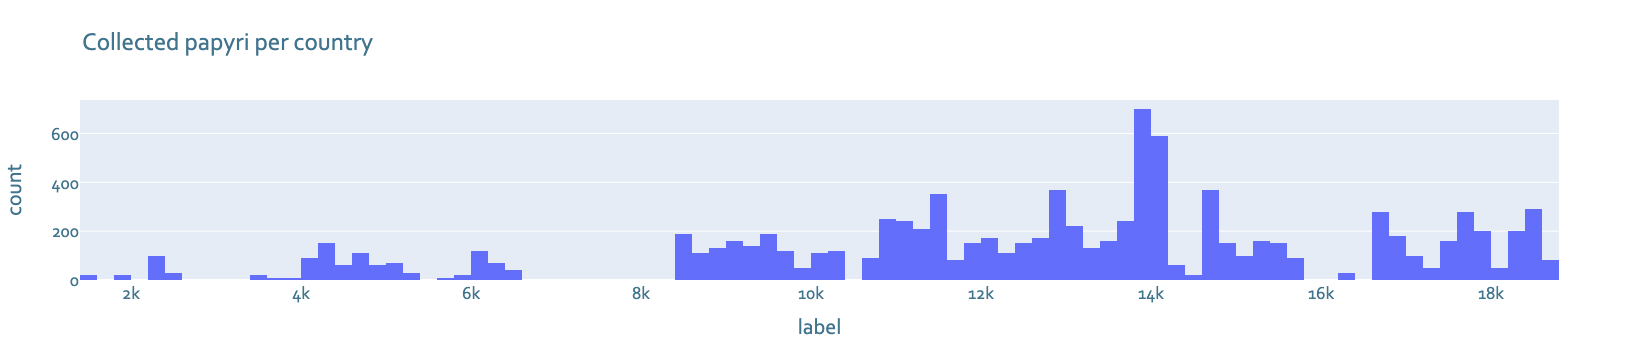

In [50]:
fig = px.histogram(val, x="label", title="Collected papyri per country")
fig.update_layout(
    autosize=True,
    font=dict(family="Corbel",size=18,color='rgb(65,116,141)'),
    #legend_title_font_color="green",
)

fig.show()

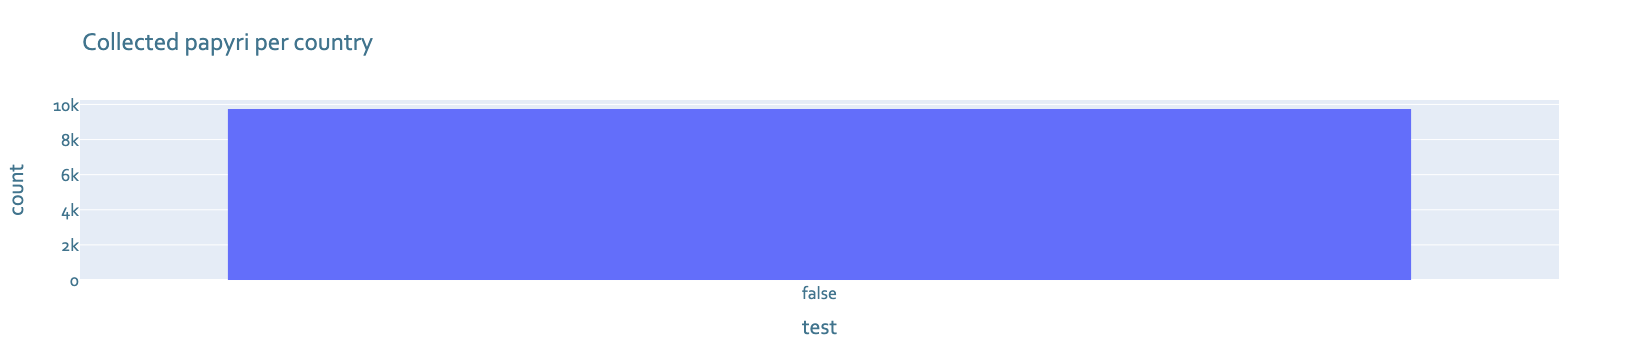

In [57]:
fig = px.histogram(val, x="test", title="Collected papyri per country")
fig.update_layout(
    autosize=True,
    font=dict(family="Corbel",size=18,color='rgb(65,116,141)'),
    #legend_title_font_color="green",
)

fig.show()

In [53]:
len(new_df)

99700

In [54]:
len(train) + len(test) + len(val)

96980

In [55]:
test.train = False
test.test = True

In [59]:
val.train = False
val.test = False
val.val = True

In [63]:
val

,Unnamed: 0,image,label,original_image,train,test,val,position,fragment,patchpixelcm,patch,pixelcm
170,170,0_0_12943_4440FR.jpg,12943,0_12943_4440FR.png,False,False,True,FR,0,NaN,0.0,228.254880
171,171,1_0_12943_4440FR.jpg,12943,0_12943_4440FR.png,False,False,True,FR,0,NaN,1.0,228.254880
172,172,2_0_12943_4440FR.jpg,12943,0_12943_4440FR.png,False,False,True,FR,0,NaN,2.0,228.254880
173,173,3_0_12943_4440FR.jpg,12943,0_12943_4440FR.png,False,False,True,FR,0,NaN,3.0,228.254880
174,174,4_0_12943_4440FR.jpg,12943,0_12943_4440FR.png,False,False,True,FR,0,NaN,4.0,228.254880
...,...,...,...,...,...,...,...,...,...,...,...,...
99625,99625,5_7_13899_4801DV.jpg,13899,7_13899_4801DV.png,False,False,True,DV,7,NaN,5.0,227.818488
99626,99626,6_7_13899_4801DV.jpg,13899,7_13899_4801DV.png,False,False,True,DV,7,NaN,6.0,227.818488
99627,99627,7_7_13899_4801DV.jpg,13899,7_13899_4801DV.png,False,False,True,DV,7,NaN,7.0,227.818488
99628,99628,8_7_13899_4801DV.jpg,13899,7_13899_4801DV.png,False,False,True,DV,7,NaN,8.0,227.818488


In [64]:
new_df = pd.concat([train,test,val])

In [67]:
new_df.drop(columns=['Unnamed: 0','patchpixelcm'],inplace=True)

In [69]:
new_df.to_csv(path + 'dataset_1/' + 'info.csv')